In [1]:
import json
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re


In [41]:
file = '/Users/mingzhangyin/Downloads/yelp_dataset/yelp_academic_dataset_review.json'
open(file)
k = 0
review_records = []
num = 300000
for line in open(file):
    if k>num:
        break
    review_records.append(json.loads(line))
    k +=1
    
with open(file) as files:
    for line in (files.readlines()[-num:]):
        review_records.append(json.loads(line))

review_records_frame = DataFrame(review_records)
ids = list(review_records_frame.business_id)

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [46]:
file = '/Users/mingzhangyin/Downloads/yelp_dataset/yelp_academic_dataset_business.json'
buisess_records = [json.loads(line) for line in open(file)]
buisess_records_frame = DataFrame(buisess_records)
a = dict(zip(buisess_records_frame.business_id, buisess_records_frame.categories))
types = [a[i] for i in ids]
rest_id = []
for i in types:
    rest_id.append('Restaurant' in str(i))

In [48]:
select_reviews = review_records_frame[rest_id] # select reviews only for restaurants
select_reviews.shape

In [50]:
review_df = select_reviews[['text', 'date']]
del(review_records_frame)

In [51]:
review_df['time'] = pd.to_datetime(review_df['date'])

/var/folders/b6/dnmgz4v90qndj_wtz10vd5rm0000gn/T/ipykernel_45560/2540852332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['time'] = pd.to_datetime(review_df['date'])


<AxesSubplot:>

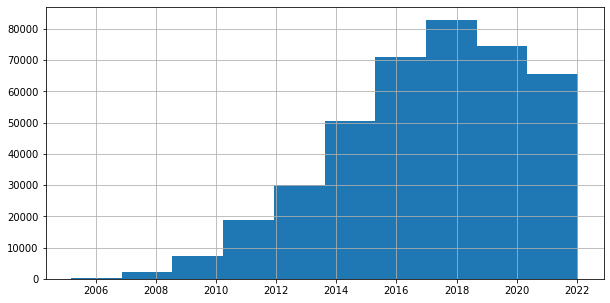

In [54]:
plt.figure(figsize=(10, 5))
review_df["time"].hist()

### Sample 1000 reviews for every half a year

In [56]:
time_list = ['2014-07-01','2015-01-01', '2015-07-01', '2016-01-01', '2016-07-01', '2017-01-01', '2017-07-01', '2018-01-01', '2018-07-01', '2019-01-01', '2019-07-01', '2020-01-01', '2020-07-01', '2021-01-01', '2021-07-01', '2022-01-01']
time_list = [pd.to_datetime(_) for _ in time_list]

In [57]:
review_df['time'][0]

Timestamp('2018-07-07 22:09:11')

In [58]:
txt_dic = {}
for i in range(len(time_list)-1):
    txt = review_df['text'][(review_df['time']>time_list[i]) & (review_df['time']<time_list[i+1])].sample(1000)
    txt_dic[str(time_list[i])[:10]] = txt
    

### preprocessing

In [91]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
import re
import string
stop_words = set(stopwords.words('english'))
lemmatizer=WordNetLemmatizer()

### pre-inflation

In [184]:
txt = list(txt_dic['2019-07-01'])
txt[0]

"Was in the mood for some biscuits and gravy this morning as i headed down keystone ave.  What better place than this hole in the wall little diner at 53rd and keystone.  Tucked back into the plaza, i walked into friendly faces, tables if what appeared to be regulars starting their day early with a gathering at the diner.\n\nSolid biscuits and gravy (they arent afraid to add a little pepper ) and hash browns with a coffee cup that stays full.  Random stop this morning...  i'll be back.."

In [185]:
txt_clean = []
for i in range(len(txt)):    
    txt[i] = re.sub(r'\d+', '', txt[i]) # remove numbers
    txt[i] = txt[i].lower()     # lower case
    txt[i] = txt[i].translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    txt[i] = txt[i].strip() # remove white space
    tokens = word_tokenize(txt[i]) # tokenize
    remove_stop = [lemmatizer.lemmatize(i) for i in tokens if not i in stop_words] # remove stop words and lemmatize
    txt_clean.append(' '.join(remove_stop))
txt_clean[0]

'mood biscuit gravy morning headed keystone ave better place hole wall little diner rd keystone tucked back plaza walked friendly face table appeared regular starting day early gathering diner solid biscuit gravy arent afraid add little pepper hash brown coffee cup stay full random stop morning ill back'

In [119]:
from bertopic import BERTopic
#from utils import *

topic_model = BERTopic(nr_topics="auto", diversity=0.2)
topics, probs = topic_model.fit_transform(txt_clean)

In [120]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,415,-1_food_place_service_menu
1,0,137,0_order_manager_minute_service
2,1,87,1_place_bar_beer_service
3,2,66,2_pizza_italian_place_pasta
4,3,54,3_shrimp_crab_sushi_food
5,4,44,4_cheese_food_ordered_sauce
6,5,34,5_bbq_beer_rib_brisket
7,6,30,6_taco_mexican_tamale_queso
8,7,26,7_nashville_biscuit_chicken_fried
9,8,20,8_thai_curry_dish_pad


In [121]:
topic_model.get_topic(0)

[('order', 0.029095501542863972),
 ('manager', 0.0233779420444587),
 ('minute', 0.022180767751165318),
 ('service', 0.02107493103492249),
 ('customer', 0.017343256761099792),
 ('table', 0.016167592847406573),
 ('drink', 0.015801245047346448),
 ('didnt', 0.015187712347756125),
 ('rude', 0.015128197909641452),
 ('restaurant', 0.013641112455260982)]

In [122]:
topic_model.get_topic(1)

[('place', 0.03123214301842017),
 ('bar', 0.022707617072018862),
 ('beer', 0.021233701774834253),
 ('service', 0.02016039887738755),
 ('fun', 0.019613965052334096),
 ('awesome', 0.015169036294266209),
 ('around', 0.014428343043110973),
 ('reno', 0.014000682045635834),
 ('friendly', 0.014000204285018721),
 ('boat', 0.013486931965559352)]

### guided topic model

In [186]:
seed_topic_list = [["service", "waiter",  "manager", "quality", "attitude"],
                   ["price", "dollar", "tip","menu",'expensive', 'cheap', 'worth']]
topic_model = BERTopic(seed_topic_list=seed_topic_list, top_n_words=20, nr_topics=20)
topics, probs = topic_model.fit_transform(txt_clean)

In [187]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,496,-1_food_place_good_great
1,0,19,0_vegan_vegetarian_menu_option
2,1,61,1_pizza_italian_place_pasta
3,2,25,2_nashville_biscuit_cheese_line
4,3,50,3_beer_bbq_great_burger
5,4,117,4_manager_order_food_service
6,5,32,5_taco_mexican_tamale_queso
7,6,49,6_crab_shrimp_great_roll
8,7,20,7_thai_curry_dish_tom
9,8,14,8_closed_food_service_restaurant


In [189]:
topic_model.get_topic(4)

[('manager', 0.030397407186182345),
 ('order', 0.02913538526408003),
 ('food', 0.025128415100367882),
 ('service', 0.02503464119756669),
 ('asked', 0.024486150964083866),
 ('said', 0.024320602998744775),
 ('minute', 0.023052995726173243),
 ('one', 0.022254865090672028),
 ('time', 0.022004206669717783),
 ('came', 0.021718863516932967),
 ('back', 0.019763317445808726),
 ('get', 0.01870519537435858),
 ('customer', 0.01840078248884209),
 ('people', 0.017593627701219625),
 ('rude', 0.01683635432196635),
 ('didnt', 0.016699757595634874),
 ('would', 0.01643673670462331),
 ('went', 0.015724176424204928),
 ('table', 0.01543808796157038),
 ('drink', 0.015311563938370874)]

In [190]:
topic_model.visualize_barchart(n_words=5)

In [191]:
# Return top3 topics that are semantically most similar to an input query term

similar_topics, similarity = topic_model.find_topics("service", top_n = 3) 


print("Most Similar Topic Info: \n{}".format(topic_model.get_topic(similar_topics[0])))
print("Similarity Score: {}".format(similarity[0]))

print("\n Most Similar Topic Info: \n{}".format(topic_model.get_topic(similar_topics[1])))
print("Similarity Score: {}".format(similarity[1]))

print("\n Most Similar Topic Info: \n{}".format(topic_model.get_topic(similar_topics[2])))
print("Similarity Score: {}".format(similarity[2]))

Most Similar Topic Info: 
[('closed', 0.09881325950322425), ('food', 0.07187445463251539), ('service', 0.059911961840330534), ('restaurant', 0.0513450839082576), ('place', 0.0500904084219234), ('area', 0.04717581328564863), ('location', 0.0453139302852862), ('best', 0.03954238268492311), ('great', 0.03759949643226223), ('excellent', 0.03598200559849409), ('sad', 0.03550030398381603), ('often', 0.034994069651370106), ('healthy', 0.034089437698007895), ('welcoming', 0.03293775316774142), ('lot', 0.032690273152792805), ('one', 0.03090953484815559), ('close', 0.030618732874939783), ('shop', 0.030152135032064948), ('friendly', 0.029718080692401085), ('im', 0.029181385796383363)]
Similarity Score: 0.632819900766685

 Most Similar Topic Info: 
[('great', 0.10037153708612374), ('service', 0.09139112823101267), ('music', 0.09044070399825625), ('fantastic', 0.07111559304522638), ('live', 0.0617852121295616), ('tuesday', 0.060971377804434124), ('band', 0.05686065638085788), ('back', 0.04851311120

In [192]:
similar_topics, similarity = topic_model.find_topics("price", top_n = 3) 


print("Most Similar Topic Info: \n{}".format(topic_model.get_topic(similar_topics[0])))
print("Similarity Score: {}".format(similarity[0]))

print("\n Most Similar Topic Info: \n{}".format(topic_model.get_topic(similar_topics[1])))
print("Similarity Score: {}".format(similarity[1]))

print("\n Most Similar Topic Info: \n{}".format(topic_model.get_topic(similar_topics[2])))
print("Similarity Score: {}".format(similarity[2]))

Most Similar Topic Info: 
[('chicken', 0.05574940718522261), ('delivery', 0.04802793028985085), ('ordered', 0.047408495338623034), ('oil', 0.04177053879599541), ('order', 0.0417113604353329), ('like', 0.0408965505430048), ('online', 0.03776704766888833), ('roll', 0.03272778814486697), ('fresh', 0.03146268342863442), ('ordering', 0.030377640490097738), ('food', 0.030168986711285987), ('always', 0.029125473894790522), ('spring', 0.02895467209139215), ('extra', 0.027691282992278767), ('tasted', 0.02643036213964319), ('two', 0.026412842758034506), ('chinese', 0.02603889434688563), ('fast', 0.02549319379745769), ('would', 0.025282656714674206), ('wrap', 0.024777374266208047)]
Similarity Score: 0.504657381215182

 Most Similar Topic Info: 
[('food', 0.02597737987429214), ('place', 0.025015005009742693), ('good', 0.024616105244701307), ('great', 0.023890087329850433), ('service', 0.023237557546591223), ('menu', 0.01711887453301003), ('back', 0.01672386526048696), ('time', 0.015320899687618144

### post-inflation

In [163]:
txt = list(txt_dic['2021-07-01'])
txt[0]

"I would sooner roll over dead than go to this McDonald's again.\n\nMy son and I walked into this McDonald's on a Thursday morning at 9:30am. The smell of fresh shit wafting through the air - their toilets were backed up and judging by the smell of it, it had been that way for a while. The workers seemed to be fine with the smell, seeing as no one was wearing a face mask. \n\nThere was a single register open. We got at the front of the line and no one helped us for at least 5 minutes. When we got up, she didn't ask if I was paying with credit card, but called at the end of the line for anyone with a credit card to come up and pay. It's 9:30am and you haven't figured out cash-purchases yet? Before I could get my card out, an Aryan family of 4 cut in front of me and ordered. \n\nMy son went up to order with a deal on the McDonald's app (which was advertised with window decals and stickers all over the store) and attempted to redeem a deal. The cashier told him they do not use the app and

In [133]:
txt_clean = []
for i in range(len(txt)):    
    txt[i] = re.sub(r'\d+', '', txt[i]) # remove numbers
    txt[i] = txt[i].lower()     # lower case
    txt[i] = txt[i].translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    txt[i] = txt[i].strip() # remove white space
    tokens = word_tokenize(txt[i]) # tokenize
    remove_stop = [lemmatizer.lemmatize(i) for i in tokens if not i in stop_words] # remove stop words and lemmatize
    txt_clean.append(' '.join(remove_stop))
txt_clean[0]

'would sooner roll dead go mcdonalds son walked mcdonalds thursday morning smell fresh shit wafting air toilet backed judging smell way worker seemed fine smell seeing one wearing face mask single register open got front line one helped u least minute got didnt ask paying credit card called end line anyone credit card come pay havent figured cashpurchases yet could get card aryan family cut front ordered son went order deal mcdonalds app advertised window decal sticker store attempted redeem deal cashier told use app ran purchase full price service terrible place smell like portajohn likely petridish covid started never go'

In [195]:
seed_topic_list = [["service", "waiter",  "manager", "quality", "attitude"],
                   ["price", "dollar", "tip","menu",'expensive', 'cheap', 'worth']]
topic_model = BERTopic(seed_topic_list=seed_topic_list, top_n_words=20, nr_topics=20, calculate_probabilities=True)
topics, probs = topic_model.fit_transform(txt_clean)

In [183]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,505,-1_place_food_good_great
1,0,10,0_italian_pasta_alfredo_oggi
2,1,35,1_pizza_slice_place_crust
3,2,19,2_vegan_vegetarian_menu_option
4,3,128,3_order_manager_service_food
5,4,43,4_beer_bbq_burger_good
6,5,24,5_nashville_cheese_biscuit_fried
7,6,38,6_taco_mexican_tamale_bean
8,7,29,7_food_service_great_place
9,8,39,8_crab_shrimp_great_meal


In [181]:
topic_model.get_topic(3)

[('order', 0.02904817533999586),
 ('manager', 0.02823993386109258),
 ('service', 0.024732983363855217),
 ('food', 0.024173797024455778),
 ('asked', 0.02259758950871481),
 ('minute', 0.021850860219033093),
 ('said', 0.021576695469594735),
 ('one', 0.021445187834026866),
 ('time', 0.02142522952653497),
 ('came', 0.01956833284919896),
 ('back', 0.018605614268696998),
 ('get', 0.018152381036838056),
 ('customer', 0.017334223326379284),
 ('people', 0.01652683057245554),
 ('would', 0.016193434667394296),
 ('table', 0.0161599056735104),
 ('didnt', 0.015941959633586533),
 ('rude', 0.015594002788630825),
 ('drink', 0.01541999447538972),
 ('went', 0.015153092197218776)]

In [174]:
topic_model.visualize_barchart(n_words=5)

In [176]:
similar_topics, similarity = topic_model.find_topics("service", top_n = 3) 


print("Most Similar Topic Info: \n{}".format(topic_model.get_topic(similar_topics[0])))
print("Similarity Score: {}".format(similarity[0]))

print("\n Most Similar Topic Info: \n{}".format(topic_model.get_topic(similar_topics[1])))
print("Similarity Score: {}".format(similarity[1]))

print("\n Most Similar Topic Info: \n{}".format(topic_model.get_topic(similar_topics[2])))
print("Similarity Score: {}".format(similarity[2]))

Most Similar Topic Info: 
[('food', 0.08530127629734538), ('service', 0.05464323475502398), ('great', 0.04846029206388202), ('place', 0.0484186534852056), ('good', 0.04564896292684885), ('area', 0.04341106805360283), ('restaurant', 0.03915833442068458), ('excellent', 0.03863908505307181), ('closed', 0.03806316779299049), ('friendly', 0.03181286959954767), ('best', 0.03174612700623657), ('location', 0.03125339988249581), ('visit', 0.026693547075990084), ('server', 0.024708815272626628), ('fantastic', 0.024559047219163455), ('enjoyed', 0.023884161420020398), ('healthy', 0.023646199384567437), ('really', 0.023566678138607935), ('staff', 0.023428685983224864), ('see', 0.02300088011368484)]
Similarity Score: 0.6398129087066582

 Most Similar Topic Info: 
[('great', 0.09358328998276212), ('music', 0.0916240622946241), ('service', 0.0915253782730989), ('live', 0.06261455273225863), ('band', 0.057771220341531496), ('fantastic', 0.05758968215504183), ('always', 0.05262616014637558), ('back', 0.

In [179]:
similar_topics, similarity = topic_model.find_topics("price", top_n = 3) 


print("Most Similar Topic Info: \n{}".format(topic_model.get_topic(similar_topics[0])))
print("Similarity Score: {}".format(similarity[0]))

print("\n Most Similar Topic Info: \n{}".format(topic_model.get_topic(similar_topics[1])))
print("Similarity Score: {}".format(similarity[1]))

print("\n Most Similar Topic Info: \n{}".format(topic_model.get_topic(similar_topics[2])))
print("Similarity Score: {}".format(similarity[2]))

Most Similar Topic Info: 
[('chicken', 0.05564303998411522), ('ordered', 0.05155032186477447), ('delivery', 0.04833325968294157), ('oil', 0.042057972617408776), ('like', 0.0407244975643554), ('online', 0.0380797306403849), ('order', 0.037395888096140126), ('didnt', 0.03387174925711055), ('ordering', 0.030550377916416904), ('spring', 0.029201207284557402), ('always', 0.029092214373052566), ('extra', 0.027814114060145362), ('food', 0.027102142832647263), ('disappointed', 0.02679343231464919), ('tasted', 0.026530078296142866), ('two', 0.026420530414905), ('roll', 0.026277426894904463), ('chinese', 0.026229866204000918), ('fresh', 0.026223321542307776), ('would', 0.02519014826972471)]
Similarity Score: 0.5129082278535722

 Most Similar Topic Info: 
[('place', 0.024993834599869046), ('food', 0.02445442452064711), ('good', 0.02335654335629392), ('great', 0.023000671209992773), ('service', 0.02183809782634149), ('menu', 0.016262808485639303), ('back', 0.01618665121134159), ('time', 0.01503443

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.plot(np.mean(topic_model.probabilities_, axis=0),'o')
# plt.vlines(x=np.arange(len(np.mean(topic_model.probabilities_, axis=0))), ymin=0, ymax=np.mean(topic_model.probabilities_, axis=0))
